# GLISS Tutorial

This tutorial demonstrates how to run GLISS, using simulated data with ground truth.

## Load Common Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

The Python source code of GLISS is under the folder `src/`, so we include the path here.

The folder `data/` includes some files and temporary outputs for this tutorial.

In [2]:
sys.path.insert(0,'src')

# Selecting SV Genes from SGE Data


### Load and Visualize Data
The coordinates and the gene expression matrix are from a simulated SGE dataset

Gene expression matrix dimension: (1045, 200)


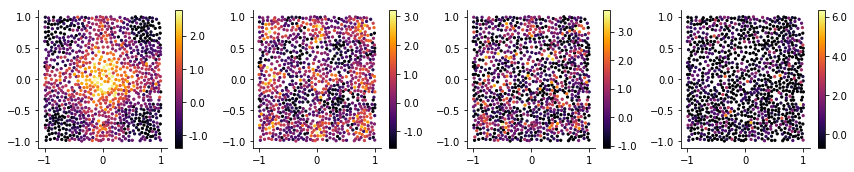

In [16]:
from io_utils import load_data_from_file
from general_utils import norm_mtx
from plot_utils import plot_multiple_scatter_continuous

locs = load_data_from_file('data/sge_locs_2d.csv', 'csv')
expr_data = load_data_from_file('data/sge_gex_mtx.csv', 'csv')
data_norm = norm_mtx(expr_data) # normalize each gene
data_norm = data_norm.values # convert from pd.dataframe to np matrix
print('Gene expression matrix dimension: {}'.format(data_norm.shape))
# plot 4 columns of the gene expression matrix
plt_gex = data_norm[data_norm.columns[[0, 30, 50, 180]]]
plot_multiple_scatter_continuous(locs, plt_gex)

### Run SV Gene selction with GLISS

- `pvals`: the pvalue of each column of the data matrix
- `rej_idx`: the indices of the selected columns of the data matrix

In [14]:
from main_methods import select_spatial_genes
# paramters
alpha= 0.05 # FDR Level
knn = 8 # number of top neighbors in constructing KNN graph
n_perm = 10000 # number of permutation for p-values
# run SV gene selection with GLISS
pvals, rej_idx = select_spatial_genes(locs, data_norm, 
                         knn=knn, alpha=alpha, n_perm=n_perm)

### Evaluate Power and FDP (Optional) 

- The ground truth was generated with 100 non-null features + 100 null features.
- The non-null features can be divided into 4 resolution groups with 25 features per group.
- With ground truth, we can compute the FDP and Power (with Power further broken down in to 4 resolutions)

In [15]:
from sim_utils import complex_eval_spatial_sim
ground_truth = pd.Series({'n_per_reg': 25, 'n_regs': 4, 
                          'temp': 'cosine', 'seed': 1}, 
                         name='truth')
complex_eval_spatial_sim(ground_truth, rej_idx)

seed                  1
temp             cosine
FDP           0.0384615
Power              0.75
Power-Reg0            1
Power-Reg1            1
Power-Reg2            1
Power-Reg3            0
Name: truth, dtype: object

# Selecting SV Genes from scRNA-seq Data

### Load scRNA-seq data matrix

- Here we assume that the LM genes are given based on the indices 0-5.
- We only visualize the non-LM genes that are order based on ground-truth groupings.

In [46]:
n_lm_genes = 6 # indices 0-5 are the LM genes
mtx = load_data_from_file('data/scrna_gex_mtx.csv', 'csv')
mtx = mtx.values # convert from pd.dataframe to np matrix
print('scRNA-seq matrix dimension: {}'.format(mtx.shape))
x_star = mtx[:, :n_lm_genes] # lm gene matrix
print('LM gene matrix dimension: {}'.format(x_star.shape))
x = mtx[:, n_lm_genes:] # non-lm gene matrix
print('non-LM gene matrix dimension: {}'.format(x.shape))

scRNA-seq matrix dimension: (1500, 6000)
LM gene matrix dimension: (1500, 6)
non-LM gene matrix dimension: (1500, 5994)


### Load the ground truth information

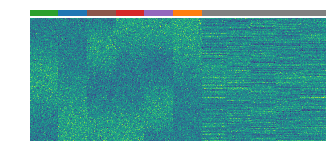

In [66]:
from plot_utils import get_sim_color_map, plot_col_color_heatmap
from sim_utils import get_top_grps
var_df  = load_data_from_file('data/scrna_truth_gene.csv', 'csv')
cell_df = load_data_from_file('data/scrna_truth_cell.csv', 'csv')
lam_true = cell_df['lam_true']

# select non-null features
df_1 = var_df.loc[var_df['nn_grp'] >= 0]
order = [2, 0, 5, 3, 4, 1]
df_1_ord = pd.DataFrame()
for grp in order:
    gdf = df_1.loc[df_1['nn_grp']==grp]
    df_1_ord = pd.concat([df_1_ord, gdf])
df_1 = df_1_ord

# select null features correlated to the lm genes
df_2 = var_df.loc[var_df['nn_grp'] == -1]
df_2 = df_2.loc[df_2['lm_corr']]
df_2 = get_top_grps(df_2, 5)
plt_sel_df = pd.concat([df_1, df_2])

def plot_data_mtx(in_mtx, df, lut, val_min=None, val_max=None, lam=[], 
                  short=False, cmap=None):
    in_mtx = in_mtx[:, df['var_id']]
    grp_ids = df['nn_grp']
    if len(lam) > 0:
        sort_idx = np.argsort(lam)
        in_mtx = in_mtx[sort_idx, :]
    plot_col_color_heatmap(in_mtx, grp_ids, lut, short=short, cmap=cmap, cax_visible=False)

plot_data_mtx(x, plt_sel_df, lut, lam=lam_true, cmap='viridis')

In [30]:
### REMOVE ME

from io_utils import save_data_to_file
rawfn = '/share/PI/sabatti/feat_viz/corr_sim/regime_2/data_dict.pkl'
dat =load_data_from_file(rawfn, 'pkl')
dat.keys()
print(dat['z'].shape)
print(dat['x'].shape)
mtx = np.concatenate([dat['z'], dat['x']], axis=1)
mtx = pd.DataFrame(mtx, columns=np.arange(mtx.shape[1]))
save_data_to_file(mtx, 'data/scrna_gex_mtx.csv', 'csv')
# scrna_mtx = dat['z']

(1500, 6000)

In [53]:
### REMOVE ME


cell_truth = pd.DataFrame({'lam_true': dat['lam']})

save_data_to_file(cell_truth, 'data/scrna_truth_cell.csv', 'csv')

In [64]:
# REMOVE ME

varfn = '/share/PI/sabatti/feat_viz/corr_sim/regime_2/var_df.csv'
var_df =load_data_from_file(varfn, 'csv')
fn = 'data/scrna_nonlm_truth.csv'
save_data_to_file(var_df, fn, 'csv')